In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from joblib import parallel_backend
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from hummingbird.ml import convert, load

C:\Users\Pabma\AppData\Local\Temp\ipykernel_20924\3539060139.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [21]:
ventas = pd.read_csv('ventas_dataframe.csv')
print(ventas)

        price_amount  makeid manufacturerprice        km  vehicleyear  \
0               9599      77             21625  152720.0         2018   
1               9990      22             21920  141485.0         2015   
2               9990      22             21920  141485.0         2015   
3               9900      84             14900  129000.0         2016   
4               8460      90             15060  117000.0         2018   
...              ...     ...               ...       ...          ...   
165749         11700      93                -   105000.0         2003   
165750         21300      10             30954  138600.0         2017   
165751       1050000      35            296454    9300.0         2015   
165752          3800      90                -   169000.0         2003   
165753          2300      77             18400  188000.0         2006   

        etiqueta_type_id  provinceid horsepower maxspeed acceleration  ...  \
0                      1          41        1

C:\Users\Pabma\AppData\Local\Temp\ipykernel_29300\1134956779.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv('ventas_dataframe.csv')


In [3]:
conn = psycopg2.connect(dbname='TFM_Coches', user='postgres', password='9170', host='127.0.0.1', port='5432')

In [4]:
cursor = conn.cursor()
query = """
    select  v.price_amount, m.make, 
	ft.manufacturerprice, v.km, ft.vehicleyear, 
	em.etiqueta_type  , p.province, 
	ft.horsepower, ft.maxspeed, ft.acceleration, 
	com.combustible_type, b.body_type, t.transmision_type,
	ft.doors, ft.seatingcapacity, c.colores_type,   
	ft.dimensionsinmillimeterswidth, ft.dimensionsinmillimetersheight,
	ft.dimensionsinmillimeterslength, ft.weight, 
	ft.tankcapacityinliters, ft.trunkcapacityinliters, 
	ft.consumptionurban, ft.consumptionmixed, ft.consumptionextraurban,  
	ft.co2emissionsgramsperkm, ft.batteryvoltage, ft.batterykwh,
	ft.chargingtime, ft.chargingtimefast 
	from ventas v 
	inner join provincias p on v.provinceid = p.provinceid
	inner join fichas_tecnicas ft on v.ficha_id = ft.id
	inner join colores c on ft.vehiclecolorid = c.colores_type_id
	inner join transmision t on ft.transmissiontypeid = t.transmision_type_id 
	inner join bodytype b on ft.bodytypeid = b.body_type_id
	inner join combustible com on ft.fueltypeid = com.combustible_type_id 
	inner join etiqueta_medioambiental em on v.etiqueta_type_id = em.etiqueta_type_id
	inner join marcas m on ft.makeid = m.makeid ;
"""

# Ejecutar la consulta y guardar los resultados en un DataFrame de pandas
ventas_preview = pd.read_sql(query, conn)

# Mostrar los primeros registros del DataFrame
print(ventas_preview.head())

# Guardar el DataFrame como un archivo CSV
ventas_preview.to_csv('ventas_dataframe_preview.csv', index=False)

# Cerrar la conexión
cursor.close()
conn.close()

C:\Users\Pabma\AppData\Local\Temp\ipykernel_20924\3774458644.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ventas_preview = pd.read_sql(query, conn)


  price_amount     make manufacturerprice      km vehicleyear etiqueta_type  \
0         9599     OPEL             21625  152720        2018             C   
1         9990  CITROEN             21920  141485        2015             C   
2         9990  CITROEN             21920  141485        2015             C   
3         9900  RENAULT             14900  129000        2016                 
4         8460     SEAT             15060  117000        2018             C   

   province horsepower maxspeed acceleration  ... tankcapacityinliters  \
0   Sevilla        110      195           11  ...                   48   
1  Valencia         99      180         11.5  ...                   60   
2    Murcia         99      180         11.5  ...                   60   
3    Madrid         75      168         14.3  ...                   45   
4  Valencia         75      167         14.7  ...                   40   

  trunkcapacityinliters consumptionurban consumptionmixed  \
0                  

In [5]:
print(ventas_preview['price_amount'].dtype)

object


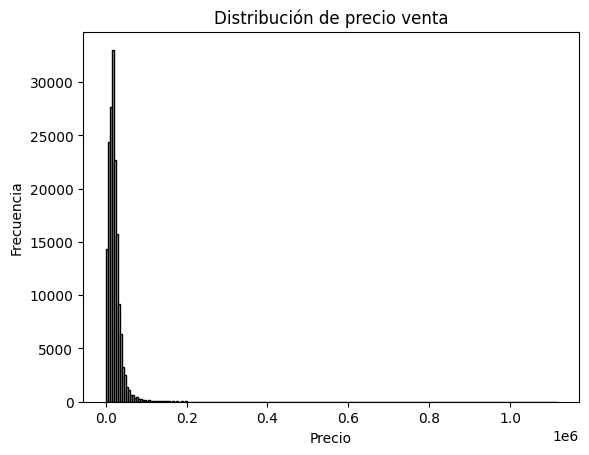

Coches mayores a 150000: 464


In [9]:
ventas_preview['price_amount'] = pd.to_numeric(ventas_preview['price_amount'], errors='coerce')
plt.hist(ventas_preview['price_amount'], bins=range(0, int(max(ventas_preview['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')
# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
# Mostrar el histograma
plt.show()
count_greater_than_150000 = ventas_preview[ventas_preview['price_amount'] > 150000]['price_amount'].count()
print('Coches mayores a 150000: ' + str(count_greater_than_150000))


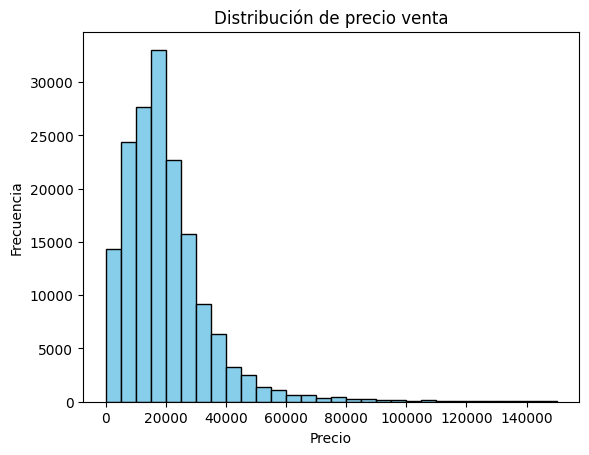

In [10]:
ventas_preview = ventas_preview[ventas_preview['price_amount'] <= 150000]

# Crear el histograma
plt.hist(ventas_preview['price_amount'], bins=range(0, int(max(ventas_preview['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

<Axes: xlabel='transmision_type'>

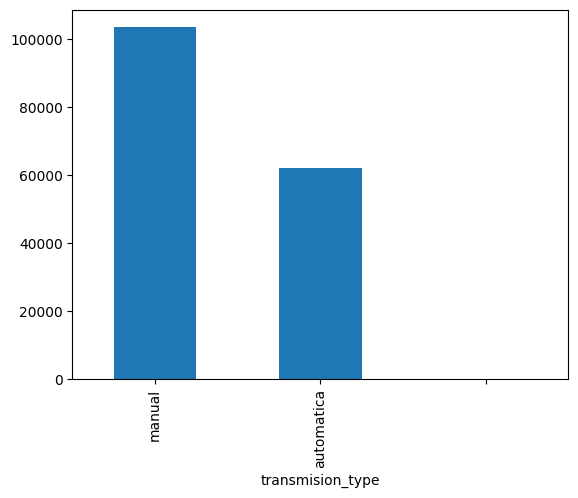

In [24]:
ventas_preview['transmision_type'].value_counts().plot(kind='bar')

<Axes: xlabel='etiqueta_type'>

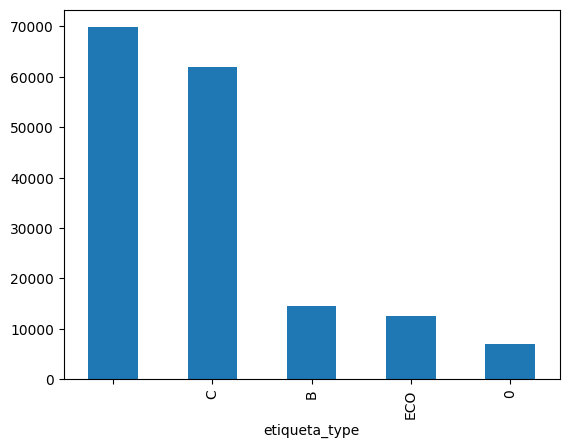

In [25]:
ventas_preview['etiqueta_type'].value_counts().plot(kind='bar')

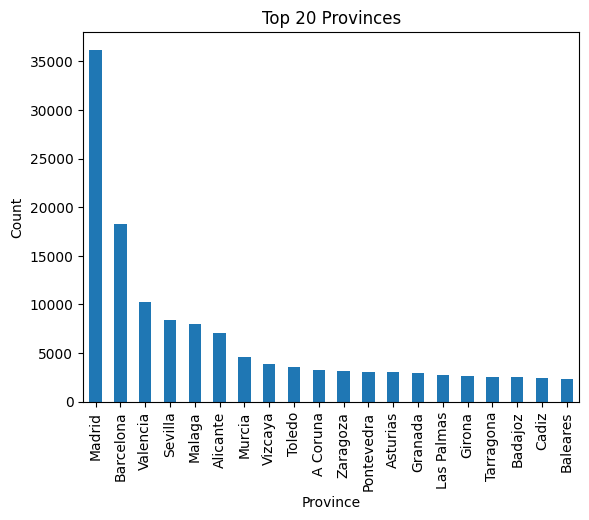

In [27]:
ventas_preview['province'].value_counts().head(20).plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Count')
plt.title('Top 20 Provinces')
plt.show()

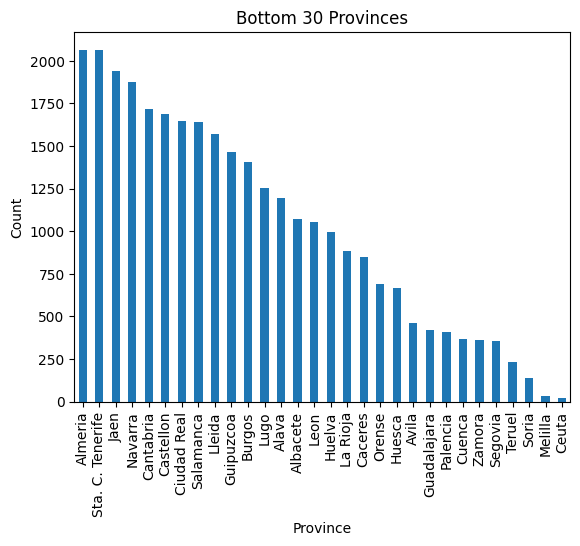

In [28]:
ventas_preview['province'].value_counts().tail(30).plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Count')
plt.title('Bottom 30 Provinces')
plt.show()

<Axes: xlabel='combustible_type'>

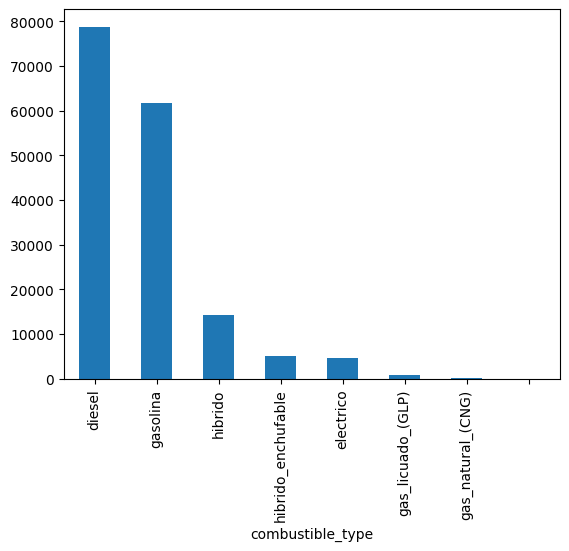

In [19]:
ventas_preview['combustible_type'].value_counts().plot(kind='bar')